# Vertex-space correlations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [2]:
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
circ_vals = ['- .6', '- .4', '- .2', '0.0', '+.2', '+.4', '+.6']

In [3]:
recon = {}
for aff in ['emotion', 'valence', 'arousal']:
    recon[aff] = {}
    for tpe in ['dynamic', 'static']:
        recon[aff][tpe] = {}
        with np.load(f'../results/validation/target-{aff}_type-{tpe}_recon.npz') as data:
            recon[aff][tpe]['S'] = data['S']
            recon[aff][tpe]['overlay'] = data['overlay']

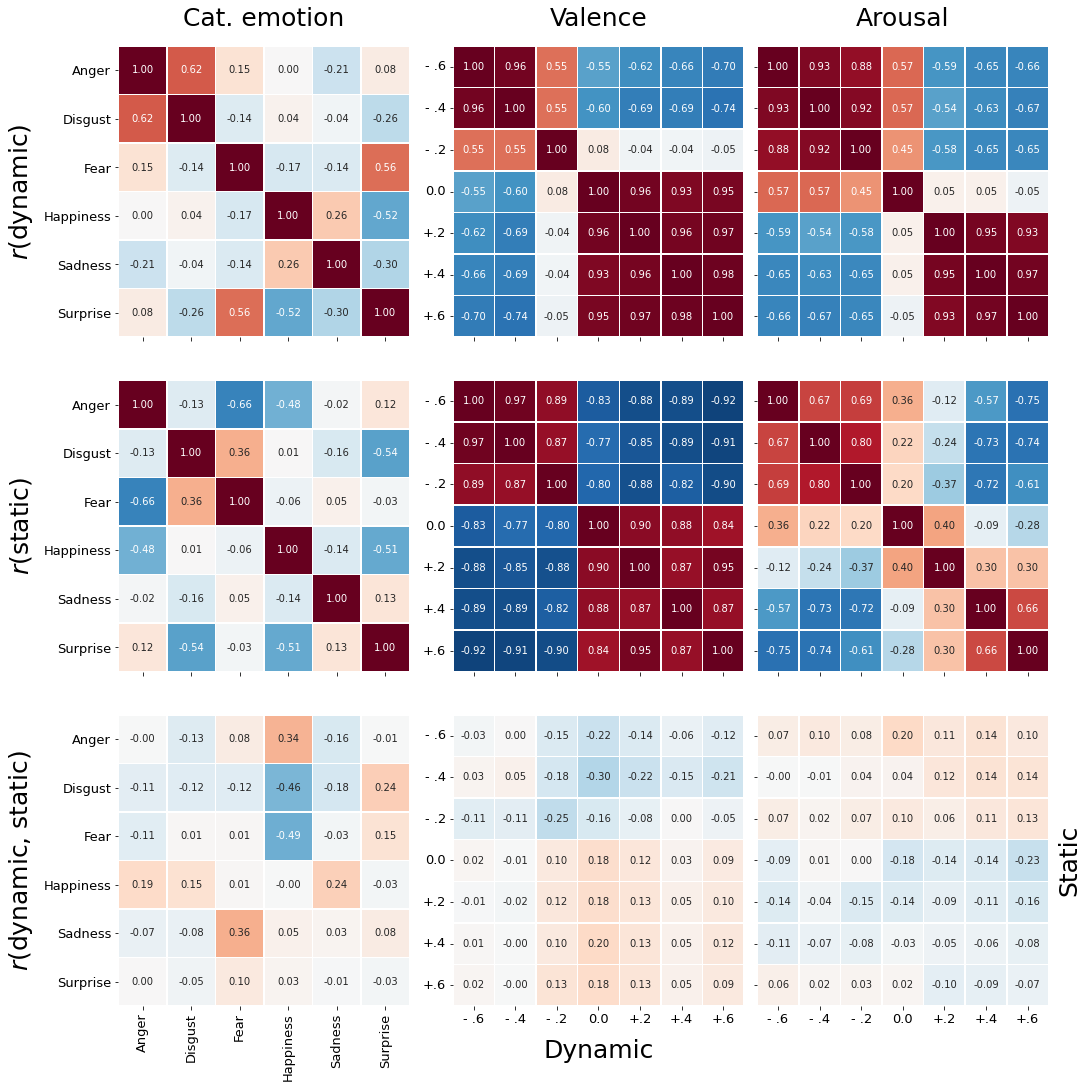

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), constrained_layout=True)
for ii, aff in enumerate(['emotion', 'valence', 'arousal']):
    stat = recon[aff]['static']['overlay']
    dyn = recon[aff]['dynamic']['overlay']
    
    for i in range(3):
        corr_mat = np.zeros((stat.shape[0], stat.shape[0]))
        if i == 0:
            corr_mat = np.corrcoef(dyn.reshape(stat.shape[0], -1))
        elif i == 1:
            corr_mat = np.corrcoef(stat.reshape(stat.shape[0], -1))
        else:
            for j in range(corr_mat.shape[0]):
                for k in range(corr_mat.shape[0]):
                    corr_mat[j, k] = pearsonr(stat[j, :, :].ravel(), dyn[k, :, :].ravel())[0]

        ax = sns.heatmap(corr_mat, cmap='RdBu_r', vmax=1, vmin=-1, center=0, cbar=False,
                         square=True, linewidths=.5, annot=True, fmt='.2f', ax=axes[i, ii])

        if ii == 0:
            axes[i, ii].set_yticklabels(emotions, fontsize=13, rotation=0)
            if i != 2:
                axes[i, ii].set_xticklabels([])
            else:
                axes[i, ii].set_xticklabels(emotions, fontsize=13, rotation=90)
        else:
            if ii == 1:
                axes[i, ii].set_yticklabels(circ_vals, fontsize=13, va='center', rotation=0)
            else:
                axes[i, ii].set_yticklabels([])
            if i != 2:
                axes[i, ii].set_xticklabels([])
            else:
                axes[i, ii].set_xticklabels(circ_vals, fontsize=13)

for ii, name in enumerate(['Cat. emotion', 'Valence', 'Arousal']):
    axes[0, ii].set_title(name, fontsize=25, pad=20)
    
for i, name in enumerate(['$r$(dynamic)', '$r$(static)', '$r$(dynamic, static)']):
    axes[i, 0].text(-2, 3, name, fontsize=25, rotation=90, va='center', ha='center')
    
axes[2, 2].text(7.5, 3.5, "Static", fontsize=25, rotation=90, va='center', ha='center')
axes[2, 1].text(3.5, 8.25, "Dynamic", fontsize=25, ha='center')
fig.savefig('../figures/figure_9.png', dpi=200)

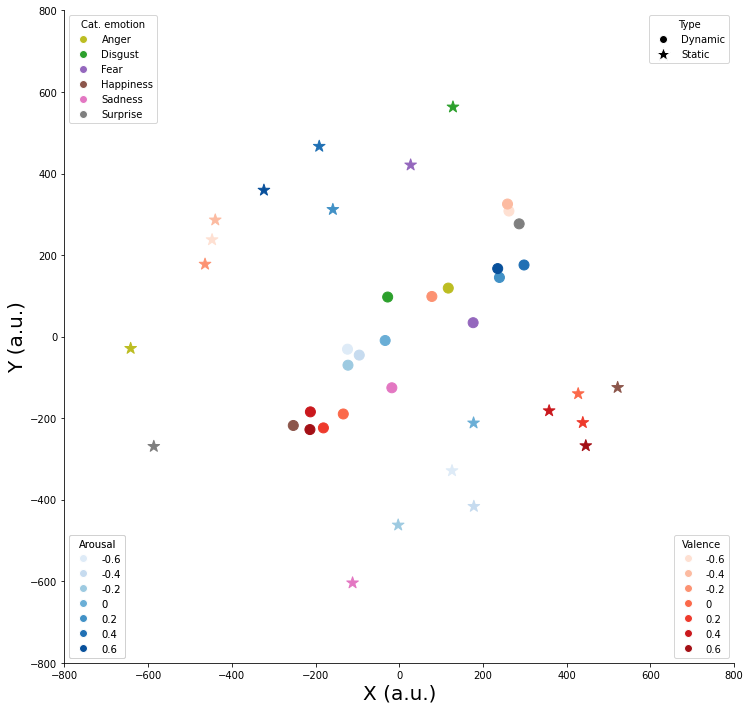

In [21]:
all_recon = np.r_[
    recon['emotion']['dynamic']['overlay'].reshape((6, -1)),
    recon['emotion']['static']['overlay'].reshape((6, -1)),
    recon['valence']['dynamic']['overlay'].reshape((7, -1)),
    recon['valence']['static']['overlay'].reshape((7, -1)),
    recon['arousal']['dynamic']['overlay'].reshape((7, -1)),
    recon['arousal']['static']['overlay'].reshape((7, -1))
]

all_recon_dyn = np.r_[
    recon['emotion']['dynamic']['overlay'].reshape((6, -1)),
    recon['valence']['dynamic']['overlay'].reshape((7, -1)),
    recon['arousal']['dynamic']['overlay'].reshape((7, -1)),
]

all_recon_stat = np.r_[
    recon['emotion']['static']['overlay'].reshape((6, -1)),
    recon['valence']['static']['overlay'].reshape((7, -1)),
    recon['arousal']['static']['overlay'].reshape((7, -1)),
]

from sklearn.manifold import MDS
mds = MDS()
all_recon_mds = mds.fit_transform(all_recon)
recon_df = pd.DataFrame(all_recon_mds, columns=['X', 'Y'])
recon_df['type'] = ['Dynamic'] * 6 + ['Static'] * 6 + ['Dynamic'] * 7 + ['Static'] * 7 + ['Dynamic'] * 7 + ['Static'] * 7
recon_df['target'] = ['Emotion'] * 12 + ['Valence'] * 14 + ['Arousal'] * 14
recon_df['level'] = [0] * 12 + [-.6, -.4, -.2, 0, .2, .4, .6] * 4

fig, ax = plt.subplots(figsize=(12, 12))
cem = sns.color_palette(n_colors=10)
cem = [cem[i] for i in [8, 2, 4, 5, 6, 7]]
vm = sns.color_palette("Reds", n_colors=7)
am = sns.color_palette("Blues", n_colors=7)
c = [cem[i] for i in range(6)] + [cem[i] for i in range(6)]
c = c + [vm[i] for i in range(7)] + [vm[i] for i in range(7)]
c = c + [am[i] for i in range(7)] + [am[i] for i in range(7)]

for m, tpe in [['o', 'Dynamic'], ['*', 'Static']]:
    idx = recon_df['type'] == tpe
    tmp = recon_df.query("type == @tpe")
    ax.scatter(tmp['X'], tmp['Y'], c=[c[i] for i in range(len(c)) if idx[i]], marker=m,
               s=100 if tpe == 'Dynamic' else 150)
    
ax.set_xlim(-800, 800)
ax.set_ylim(-800, 800)

from matplotlib.lines import Line2D
emo_ = [Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=cem[i], label=emotions[i])
        for i in range(6)]

type_ = [Line2D([0], [0], marker=m, color='w', markersize=ms, markerfacecolor='k', label=s)
         for (m, ms, s) in [['o', 8, 'Dynamic'], ['*', 15, 'Static']]]

val_ = [Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=vm[i], label=s)
         for i, s in enumerate([-.6, -.4, -.2, 0, .2, .4, .6])]

aro_ = [Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=am[i], label=s)
        for i, s in enumerate([-.6, -.4, -.2, 0, .2, .4, .6])]

leg1 = ax.legend(handles=emo_, loc='upper left', title='Cat. emotion')
leg2 = ax.legend(handles=type_, loc='upper right', title='Type')
leg3 = ax.legend(handles=val_, loc='lower right', title='Valence')
leg4 = ax.legend(handles=aro_, loc='lower left', title='Arousal')

ax.add_artist(leg1)
ax.add_artist(leg2)
ax.add_artist(leg3)
ax.add_artist(leg4)

ax.set_xlabel('X (a.u.)', fontsize=20)
ax.set_ylabel('Y (a.u.)', fontsize=20)

sns.despine()
fig.savefig('../figures/figure_S7.png', dpi=200)

[Text(0, 0.5, 'Anger'),
 Text(0, 1.5, 'Disgust'),
 Text(0, 2.5, 'Fear'),
 Text(0, 3.5, 'Happiness'),
 Text(0, 4.5, 'Sadness'),
 Text(0, 5.5, 'Surprise'),
 Text(0, 6.5, '- .6'),
 Text(0, 7.5, '- .4'),
 Text(0, 8.5, '- .2'),
 Text(0, 9.5, '0.0'),
 Text(0, 10.5, '+.2'),
 Text(0, 11.5, '+.4'),
 Text(0, 12.5, '+.6'),
 Text(0, 13.5, '- .6'),
 Text(0, 14.5, '- .4'),
 Text(0, 15.5, '- .2'),
 Text(0, 16.5, '0.0'),
 Text(0, 17.5, '+.2'),
 Text(0, 18.5, '+.4'),
 Text(0, 19.5, '+.6')]

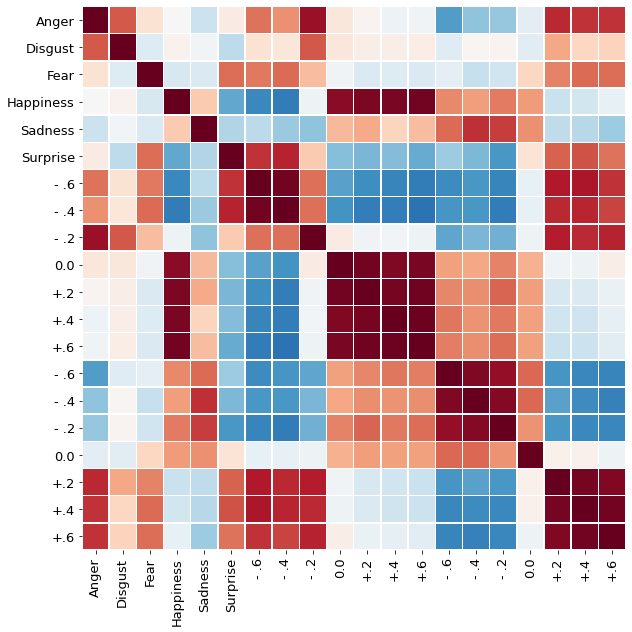

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(np.corrcoef(all_recon_dyn), cmap='RdBu_r', vmax=1, vmin=-1, center=0, cbar=False,
                 square=True, linewidths=.5, annot=False, ax=ax)

#val_vals = ['Valence: ' + c for c in circ_vals]
#aro_vals = ['Aroursal: ' + c for c in circ_vals]
val_vals = circ_vals
aro_vals = circ_vals
ax.set_xticklabels(emotions + val_vals + aro_vals, fontsize=13, rotation=90)
ax.set_yticklabels(emotions + val_vals + aro_vals, fontsize=13, rotation=0) 

[Text(0, 0.5, 'Anger'),
 Text(0, 1.5, 'Disgust'),
 Text(0, 2.5, 'Fear'),
 Text(0, 3.5, 'Happiness'),
 Text(0, 4.5, 'Sadness'),
 Text(0, 5.5, 'Surprise'),
 Text(0, 6.5, '- .6'),
 Text(0, 7.5, '- .4'),
 Text(0, 8.5, '- .2'),
 Text(0, 9.5, '0.0'),
 Text(0, 10.5, '+.2'),
 Text(0, 11.5, '+.4'),
 Text(0, 12.5, '+.6'),
 Text(0, 13.5, '- .6'),
 Text(0, 14.5, '- .4'),
 Text(0, 15.5, '- .2'),
 Text(0, 16.5, '0.0'),
 Text(0, 17.5, '+.2'),
 Text(0, 18.5, '+.4'),
 Text(0, 19.5, '+.6')]

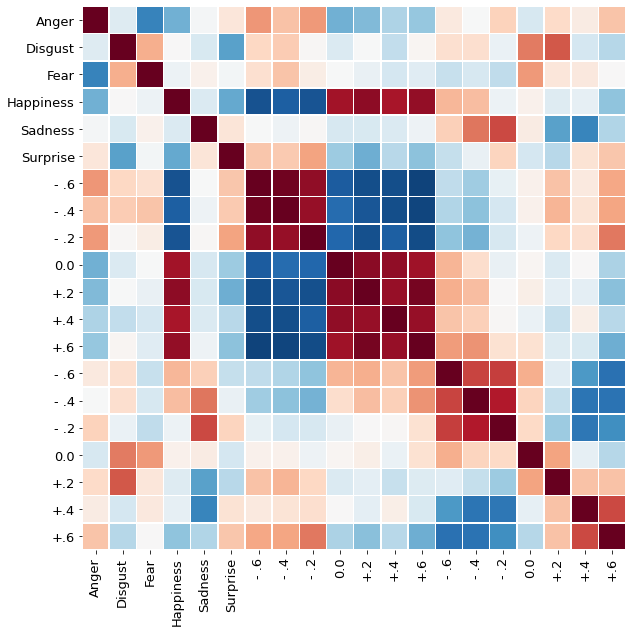

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(np.corrcoef(all_recon_stat), cmap='RdBu_r', vmax=1, vmin=-1, center=0, cbar=False,
                 square=True, linewidths=.5, annot=False, ax=ax)

#val_vals = ['Valence: ' + c for c in circ_vals]
#aro_vals = ['Aroursal: ' + c for c in circ_vals]
val_vals = circ_vals
aro_vals = circ_vals
ax.set_xticklabels(emotions + val_vals + aro_vals, fontsize=13, rotation=90)
ax.set_yticklabels(emotions + val_vals + aro_vals, fontsize=13, rotation=0) 